In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
import csv
import pandas as pd
import random
from datetime import datetime
from operator import itemgetter
import os
import json
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ndcg_score
from sklearn.metrics import dcg_score,classification_report
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, validation_curve
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
import math 
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier


In [0]:

def get_paths():
    paths = json.loads(open("/content/drive/My Drive/Colab Notebooks/SETTINGS.json").read())
    for key in paths:
        paths[key] = os.path.expandvars(paths[key])
    return paths

def read_train():
    print("Reading training data...")
    tstart = datetime.now()
    train_path = get_paths()["train_path"]
    x = pd.read_csv(train_path)
    # print the time interval
    print("Time used,")
    print(datetime.now() - tstart)
    return x

def read_test():
    print("Reading test data...")
    tstart = datetime.now()
    test_path = get_paths()["test_path"]
    x = pd.read_csv(test_path)
    print("Time used,")
    print(datetime.now() - tstart)
    return x

def save_model(model, isBook=True):
    if isBook:
        out_path = get_paths()["model_path_book"]
    else:
        out_path = get_paths()["model_path_click"]
    pickle.dump(model, open(out_path, "wb"))

def load_model(isBook=True):
    if isBook:
        in_path = get_paths()["model_path_book"]
    else:
        in_path = get_paths()["model_path_click"]
    return pickle.load(open(in_path,'rb'))

def write_submission(recommendations, submission_file=None):
    if submission_file is None:
        submission_path = get_paths()["submission_path"]
    else:
        path, file_name = os.path.split(get_paths()["submission_path"])
        submission_path = os.path.join(path, submission_file)
    rows = [(srch_id, prop_id)
        for srch_id, prop_id, rank_float
        in sorted(recommendations, key=itemgetter(0,2))]
    writer = csv.writer(open(submission_path, "w"), lineterminator="\n")
    writer.writerow(("srch_id", "prop_id"))
    writer.writerows(rows)


In [9]:

def get_features(train, isBook=True):
    feature_names = train.columns.values.tolist()

    if "comp1_rate" in feature_names:
        ## only true in the test set
        feature_names.remove("comp1_rate")
    if "position" in feature_names:
        ## only true in the training set
        feature_names.remove("position")
        
    feature_names.remove("date_time")
    feature_names.remove("srch_id")
    feature_names.remove("visitor_hist_starrating")
    if isBook:
        feature_names.append("visitor_hist_starrating_bool")
        #print(train['visitor_hist_starrating_bool'])
    feature_names.append("comp_rate_sum")
    feature_names.append("comp_inv_sum")
    return feature_names


def feature_eng(train):
  loc_q = train.groupby("prop_country_id")["prop_location_score2"].quantile(q=0.25)
  train["prop_location_score2_quartile"] = loc_q.reindex([train.prop_id]).values
  train["prop_location_score2"].fillna(train["prop_location_score2_quartile"])
  train.fillna(-1, inplace=True)
  numeric_features = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2"]

  for label in numeric_features:
    mean = train.groupby("prop_id")[label].mean().fillna(value=-1)
    median = train.groupby("prop_id")[label].median().fillna(value=-1)
    std = train.groupby("prop_id")[label].std().fillna(value=-1)
    train[label + "_mean"] = mean[train.prop_id].values
    train[label + "_median"] = median[train.prop_id].values
    train[label + "_std"] = std[train.prop_id].values

  feature_labels = train.columns.values.tolist()
  remove = []
  for i in range(1,9):
    remove += ["comp%d_rate" % i, "comp%d_inv" % i, "comp%d_rate_percent_diff" % i]
  remove += ["srch_query_affinity_score","click_bool","booking_bool","visitor_hist_adr_usd","visitor_hist_starrating"]
  remove += ["position","gross_bookings_usd","srch_id","prop_id"]
  for label in remove:
    feature_labels.remove(label)
  train = train[train["price_usd"] < 10000]
  train["count_window"] = train["srch_room_count"] * max(train["srch_booking_window"]) + train["srch_booking_window"]
  feature_labels.append("count_window")
  train_datetime = pd.DatetimeIndex(train.date_time)
  train["month"] = train_datetime.month
  train["week"] = train_datetime.week
  train["day"] = train_datetime.dayofweek + 1
  train["hour"] = train_datetime.hour
  feature_labels += ["month", "week", "day", "hour"]
  feature_labels.remove("date_time")

  train["prop_historical_price"] = (np.e ** train["prop_log_historical_price"]).replace(1.0, 10000)
  feature_labels.append("prop_historical_price")
  feature_labels.remove("prop_log_historical_price")
  train["target"] = np.fmax((train["booking_bool"]*5).values, train["click_bool"].values)

  df_0 = train[train.click_bool == 0]
  df_1 = train[train.click_bool == 1]
  df_0 = df_0.sample(df_1["srch_id"].count())
  train = pd.concat([df_0,df_1])
  return train, feature_labels
    
    # train['prop_review_score'].fillna(3, inplace=True)
    # train['prop_review_score'][train['prop_review_score']==0]=2.5
    # train["prop_location_score2"].fillna(0, inplace=True)
    # avg_srch_score = train["srch_query_affinity_score"].mean()
    # train["srch_query_affinity_score"].fillna(avg_srch_score, inplace=True)
    # train["orig_destination_distance"].fillna(1509,inplace=True)
    # train["visitor_hist_adr_usd"].fillna(0, inplace=True)
    # train['visitor_hist_starrating_bool'] = pd.notnull(train['visitor_hist_starrating'])
    
    ## add feature: comp_rate_sum
    # for i in range(1,9):
    #     train['comp'+str(i)+'_rate'].fillna(0, inplace=True)
    # train['comp_rate_sum'] = train['comp1_rate']
    # for i in range(2,9):
    #     train['comp_rate_sum'] += train['comp'+str(i)+'_rate']

    # ## add feature: comp_rate_sum
    # for i in range(1,9):
    #     train['comp'+str(i)+'_inv'].fillna(0, inplace=True)
    #     train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==1] = 10
    #     train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==-1] = 1
    #     train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==0] = -1
    #     train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==10] = 0
    # train['comp_inv_sum'] = train['comp1_inv']
    # for i in range(2,9):
        #train['comp_inv_sum'] += train['comp'+str(i)+'_inv']

    #sample_size = int(sys.argv[1])
    ## sample_size = int(1000)

train = read_train()
#sample_size = 4958347
print("Data Size:")
print(train.shape)

train, feature_labels = feature_eng(train)

#print(train)
train.head(5)
print(feature_labels)


Reading training data...
Time used,
0:00:34.824851
Data Size:
(4958347, 54)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

['site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool', 'prop_location_score2_quartile', 'prop_starrating_mean', 'prop_starrating_median', 'prop_starrating_std', 'prop_review_score_mean', 'prop_review_score_median', 'prop_review_score_std', 'prop_location_score1_mean', 'prop_location_score1_median', 'prop_location_score1_std', 'prop_location_score2_mean', 'prop_location_score2_median', 'prop_location_score2_std', 'count_window', 'month', 'week', 'day', 'hour', 'prop_historical_price']


In [10]:
train.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,prop_location_score2_quartile,prop_starrating_mean,prop_starrating_median,prop_starrating_std,prop_review_score_mean,prop_review_score_median,prop_review_score_std,prop_location_score1_mean,prop_location_score1_median,prop_location_score1_std,prop_location_score2_mean,prop_location_score2_median,prop_location_score2_std,count_window,month,week,day,hour,prop_historical_price,target
1067709,71317,2013-01-04 15:59:35,18,129,-1.0,-1.0,132,90120,5,4.0,1,5.82,0.6121,5.77,1,175.12,1,27231,4,1,2,0,1,1,-1.0,124.91,0,1.0,0.0,6.0,-1.0,-1.0,-1.0,-1.0,0.0,11.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,4.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0,-1.0,0,-1.0,5,5,0.0,4.0,4.0,0.0,5.82,5.82,0.0,0.333815,0.1829,0.214767,493,1,1,5,15,320.537733,0
4003673,268677,2013-06-22 13:21:25,5,219,-1.0,-1.0,99,35609,2,0.0,0,1.95,-1.0000,0.00,26,66.00,0,1658,1,14,2,0,1,1,-1.0,5429.86,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1.0,0,-1.0,2,2,0.0,0.0,0.0,0.0,1.95,1.95,0.0,-1.000000,-1.0000,0.000000,506,6,25,6,13,10000.000000,0
90455,6061,2013-05-02 23:57:23,4,50,-1.0,-1.0,219,62596,3,4.0,0,4.91,0.0803,5.59,18,260.80,0,23605,3,253,2,2,1,1,-1.0,4082.62,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1.0,0,-1.0,3,3,0.0,4.0,4.0,0.0,4.91,4.91,0.0,0.280188,0.4050,0.296119,745,5,18,4,23,267.735620,0
3629940,243859,2013-05-20 10:34:59,14,100,-1.0,-1.0,100,25684,5,4.5,1,4.39,0.0727,5.75,7,280.25,1,6792,2,68,2,2,1,1,-1.0,455.13,0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1.0,0,-1.0,5,5,0.0,4.5,4.5,0.0,4.39,4.39,0.0,0.039782,0.0727,0.322856,560,5,21,1,10,314.190660,0
205544,13826,2012-12-23 07:10:21,5,219,-1.0,-1.0,219,117751,5,4.5,1,4.66,0.5796,6.20,34,295.00,0,17759,2,5,3,1,1,1,-1.0,262.88,0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0,-1.0,0,-1.0,5,5,0.0,4.5,4.5,0.0,4.66,4.66,0.0,0.333898,0.5540,0.400808,497,12,51,7,7,492.749041,0


In [0]:
def model():
  
  LogReg_clf = LogisticRegression()

  ada = AdaBoostClassifier(learning_rate=0.01, n_estimators=1000)

  DTree_clf = DecisionTreeClassifier(
      class_weight=None,
      criterion='gini',
      max_depth=14,
      max_features='sqrt',
      max_leaf_nodes=10,
      min_impurity_split=1e-07,
      min_samples_leaf=1,
      min_samples_split=2,
      min_weight_fraction_leaf=0.0,
      presort=False,
      random_state=1,
      splitter='best',
      )
  
  lgb = LGBMClassifier(
      learning_rate=0.01,
      boosting_type='gbdt',
      objective='multiclass',
      num_class=3,
      metric='multi_logloss',
      sub_feature=0.5,
      num_leaves=10,
      min_data=50,
      max_depth=10,
      )

  xgb = XGBClassifier(
      base_score=0.5,
      booster='gbtree',
      colsample_bylevel=1,
      colsample_bynode=1,
      colsample_bytree=0.6,
      gamma=0.2,
      learning_rate=0.1,
      max_depth=10,
      min_child_weight=1,
      missing=None,
      n_estimators=1000,
      n_jobs=1,
      nthread=None,
      objective='multiclass',
      reg_alpha=0.05,
      reg_lambda=1,
      scale_pos_weight=1,
      seed=27,
      silent=None,
      subsample=0.5,
      verbosity=2,
      )

  rf = RandomForestClassifier(
      n_estimators=100,
      verbose=2,
      n_jobs=1,
      min_samples_split=8,
      max_depth=20,
      min_samples_leaf=1,
      max_features='auto',
      random_state=1,
      )

  gbc = GradientBoostingClassifier(
      loss='deviance',
      n_estimators=1000,
      subsample=1,
      learning_rate=0.01,
      min_samples_split=100,
      min_samples_leaf=50,
      max_depth=12,
      init=None,
      random_state=1,
      max_features='sqrt',
      criterion='friedman_mse',
      verbose=6,
      )

  # ('SVC', SVC_clf),, ('LogReg', LogReg_clf)

  return VotingClassifier(estimators=[('XGB', xgb)], voting='soft')


In [0]:

# #print(train_set)
# book_trainset = train_set[train_set['booking_bool']==1]
# #print(book_trainset)
# book_rows = book_trainset.index.tolist()
# #print(book_rows)
# bsize = len(book_trainset.index)
# click_trainset = train_set[train_set['click_bool']==1]
# click_rows = click_trainset.index.tolist()
# csize = len(click_trainset.index)
# print ('bsize ' + str(bsize))
# print ('csize ' + str(csize))



bsize 138390
csize 221879


In [0]:
book_trainset = book_trainset.append(train_set.iloc[random.sample(list(train_set.drop(book_rows).index), bsize)])
click_trainset =click_trainset.append(train_set.iloc[random.sample(list(train_set.drop(click_rows).index), csize)])


In [13]:
# for i in range(0,2):
#   if i==0:

#     model_name = "Booking"
#     response_name = "booking_bool"
#     train_sample = book_trainset
#     isBook = True
#   else:
#     model_name = "Click"
#     response_name = "click_bool"
#     train_sample = click_trainset
#     isBook = False


print("Training the Classifier...")
tstart = datetime.now()
print("feature names: ", feature_labels)
  
X_train = train[feature_labels].values
y_train = train["target"].values

X1_train, X2_test, y1_train, y2_test = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

  
  
  

#   param_test1 = {
#  'gamma':[i/10.0 for i in range(0,5)]
#   }
  #gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
  #min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
  #objective= 'rank:pairwise', nthread=4, scale_pos_weight=1, seed=27), 
  #param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
  #gsearch1.fit(features_train, target_train)
  #print( gsearch1.best_params_, gsearch1.best_score_)

classifier = model()
class_fit = classifier.fit(X1_train, y1_train)
exp_pred = class_fit.predict(X2_test)
print(exp_pred)
print(class_fit)
acc_score = metrics.accuracy_score(y2_test, exp_pred)
print(acc_score)



print("Time used,")
print (datetime.now() - tstart)
print("Saving the classifier...")
tstart = datetime.now()
save_model(classifier, True)
print("Time used,")
print (datetime.now() - tstart)








Training the Classifier...
feature names:  ['site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool', 'prop_location_score2_quartile', 'prop_starrating_mean', 'prop_starrating_median', 'prop_starrating_std', 'prop_review_score_mean', 'prop_review_score_median', 'prop_review_score_std', 'prop_location_score1_mean', 'prop_location_score1_median', 'prop_location_score1_std', 'prop_location_score2_mean', 'prop_location_score2_median', 'prop_location_score2_std', 'count_window', 'month', 'week', 'day', 'hour', 'prop_historical_price']
[12:15:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1682 extra nodes, 8 pruned nodes, 

In [17]:

def feature_eng_test(train):
  loc_q = train.groupby("prop_country_id")["prop_location_score2"].quantile(q=0.25)
  train["prop_location_score2_quartile"] = loc_q.reindex([train.prop_id]).values
  train["prop_location_score2"].fillna(train["prop_location_score2_quartile"])
  train.fillna(-1, inplace=True)
  numeric_features = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2"]

  for label in numeric_features:
    mean = train.groupby("prop_id")[label].mean().fillna(value=-1)
    median = train.groupby("prop_id")[label].median().fillna(value=-1)
    std = train.groupby("prop_id")[label].std().fillna(value=-1)
    train[label + "_mean"] = mean[train.prop_id].values
    train[label + "_median"] = median[train.prop_id].values
    train[label + "_std"] = std[train.prop_id].values

  feature_labels = train.columns.values.tolist()
  remove = []
  for i in range(1,9):
    remove += ["comp%d_rate" % i, "comp%d_inv" % i, "comp%d_rate_percent_diff" % i]
  remove += ["srch_query_affinity_score","visitor_hist_adr_usd","visitor_hist_starrating"]
  remove += ["srch_id","prop_id"]
  for label in remove:
    feature_labels.remove(label)
  #train = train[train["price_usd"] < 10000]
  train["count_window"] = train["srch_room_count"] * max(train["srch_booking_window"]) + train["srch_booking_window"]
  feature_labels.append("count_window")
  train_datetime = pd.DatetimeIndex(train.date_time)
  train["month"] = train_datetime.month
  train["week"] = train_datetime.week
  train["day"] = train_datetime.dayofweek + 1
  train["hour"] = train_datetime.hour
  feature_labels += ["month", "week", "day", "hour"]
  feature_labels.remove("date_time")

  train["prop_historical_price"] = (np.e ** train["prop_log_historical_price"]).replace(1.0, 10000)
  feature_labels.append("prop_historical_price")
  feature_labels.remove("prop_log_historical_price")
  train["target"] = 0

  return train, feature_labels

test = read_test()
    ## deal with the NAs, and add features
test, feature_labels = feature_eng_test(test)

X2_test = test[feature_labels].values
    ## predict the booking_bool
print("Loading the classifier..")
# tstart = datetime.now()
# classifier = load_model(True)
print("Time used,")
print(datetime.now() - tstart)
print("Making predictions on the..")
tstart = datetime.now()
#b_fnames = get_features(test, True)
y2_test = class_fit.predict(X2_test)
print(y2_test)
print("Time used,")
print(datetime.now() - tstart)

    ## Making Recommendations
# recommendations = zip(test["srch_id"], test["prop_id"], y2_test)
# # recommendations.head(5)    
# # print("Writing predictions to file..")
# # tstart = datetime.now()
# write_submission(recommendations)
# print("Time used,")
# print(datetime.now() - tstart)

Reading test data...
Time used,
0:00:26.375102
Loading the classifier..
Time used,
0:21:40.268242
Making predictions on the..
[0 0 0 ... 0 5 5]
Time used,
1:13:24.740115


AttributeError: ignored

In [0]:
recommendations = zip(test["srch_id"], test["prop_id"], y2_test)
# recommendations.head(5)    
# print("Writing predictions to file..")
# tstart = datetime.now()
write_submission(recommendations)

In [20]:
print(y2_test)
test["target"] = y2_test
test.sort_values(by=["srch_id","target","prop_id"],ascending=[True,False,True],inplace=True)


[0 0 0 ... 0 5 5]


In [0]:
submission = test[["srch_id","prop_id"]]
submission.to_csv("/content/drive/My Drive/Colab Notebooks/submissions/xgboost_2_expedia.csv",index=False)

In [22]:
test[test.target == 1]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,prop_location_score2_quartile,prop_starrating_mean,prop_starrating_median,prop_starrating_std,prop_review_score_mean,prop_review_score_median,prop_review_score_std,prop_location_score1_mean,prop_location_score1_median,prop_location_score1_std,prop_location_score2_mean,prop_location_score2_median,prop_location_score2_std,count_window,month,week,day,hour,prop_historical_price,target
56,6,2012-12-16 00:06:37,4,50,-1.0,-1.0,50,5333,3,0.0,0,2.77,-1.0000,5.15,81.50,0,9721,8,75,2,0,1,0,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,3,0.0,0.0,0.0,0.0,2.77,2.77,0.0,-1.000000,-1.0000,0.000000,573,12,50,7,0,172.431490,1
57,6,2012-12-16 00:06:37,4,50,-1.0,-1.0,50,22970,4,0.0,1,2.40,-1.0000,5.15,203.26,0,9721,8,75,2,0,1,0,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,4,0.0,0.0,0.0,0.0,2.40,2.40,0.0,-1.000000,-1.0000,0.000000,573,12,50,7,0,172.431490,1
58,6,2012-12-16 00:06:37,4,50,-1.0,-1.0,50,24695,3,0.0,0,2.71,0.6667,5.15,104.99,0,9721,8,75,2,0,1,0,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,3,0.0,0.0,0.0,0.0,2.71,2.71,0.0,-0.055560,0.0185,0.597930,573,12,50,7,0,172.431490,1
59,6,2012-12-16 00:06:37,4,50,-1.0,-1.0,50,31470,3,0.0,0,2.77,0.3334,5.15,149.57,0,9721,8,75,2,0,1,0,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,3,0.0,0.0,0.0,0.0,2.77,2.77,0.0,-0.106620,0.0445,0.514844,573,12,50,7,0,172.431490,1
60,6,2012-12-16 00:06:37,4,50,-1.0,-1.0,50,49926,3,4.0,0,1.79,-1.0000,5.15,189.36,0,9721,8,75,2,0,1,0,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,3,0.0,4.0,4.0,0.0,1.79,1.79,0.0,-1.000000,-1.0000,0.000000,573,12,50,7,0,172.431490,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959151,332785,2013-03-12 15:51:20,16,31,-1.0,-1.0,56,127539,4,4.5,1,5.00,0.0923,5.38,168.12,0,14490,3,30,2,0,1,1,-1.0,388.77,1,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,4,0.0,4.5,4.5,0.0,5.00,5.00,0.0,0.040370,0.0428,0.163329,528,3,11,2,15,217.022275,1
4959152,332785,2013-03-12 15:51:20,16,31,-1.0,-1.0,56,131198,4,3.5,1,4.98,0.1131,5.28,347.97,0,14490,3,30,2,0,1,1,-1.0,388.70,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,4,0.0,3.5,3.5,0.0,4.98,4.98,0.0,0.026412,0.1131,0.245818,528,3,11,2,15,196.369875,1
4959158,332786,2013-03-30 16:39:40,5,219,-1.0,-1.0,219,36331,3,4.5,0,3.04,0.1379,5.76,169.00,1,7037,1,3,2,2,1,0,-1.0,2564.92,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,7.0,-1.0,-1.0,-1.0,0.0,0.0,7.0,-

In [0]:

def dcg_score (y_true, y_score, k=5, gains = "exponential"):
    """Discounted cumulative gain (DCG) at rank k
    Parameters
    ----------
    y_true: array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score: array-like, shape = [n_samples]
        Predicted scores.
    k: int
        Rank.
    gains: str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    DCG @k: float
    """
    
    order = np.argsort (y_score) [::-1]
    y_true = np.take (y_true, order [: k])

    if gains == "exponential":
        gains = 2 ** y_true-1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError ("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2 (np.arange (len (y_true)) + 2)
    return np.sum (gains / discounts)



k = 5
gains = "exponential"
y_true = target_test
y_score = exp_pred
best = dcg_score (y_true, y_true, k, gains)
actual = dcg_score (y_true, y_score, k, gains)
print(best)
print(actual)

res = actual/best
print(res)


2.9484591188793923
2.5616063116448506
0.8687949224876582


In [0]:


test = read_test()
    ## deal with the NAs, and add features
feature_eng(test)

    ## predict the booking_bool
print("Loading the Booking classifier..")
tstart = datetime.now()
classifier = load_model(True)
print("Time used,")
print(datetime.now() - tstart)
print("Making predictions on the booking_bool..")
tstart = datetime.now()
b_fnames = get_features(test, True)
b_test_f =  test[b_fnames].values
b_prob = classifier.predict_proba(b_test_f)[:,1]
print(b_prob)
b_prob = list(-1.0*b_prob)

print("Time used,")
print(datetime.now() - tstart)

    ## predict the click_bool
print("Loading the Click classifier..")
tstart = datetime.now()
classifier = load_model(False)
print("Time used,")
print(datetime.now() - tstart)
print("Making predictions on the click_bool..")
tstart = datetime.now()
c_fnames = get_features(test, False)
c_test_f =  test[c_fnames].values
c_prob = classifier.predict_proba(c_test_f)[:,1]
print(c_prob)
c_prob = list(-1.0*c_prob)
print("Time used,")
print(datetime.now() - tstart)

    ## Making Recommendations
recommendations = zip(test["srch_id"], test["prop_id"], 4*b_prob+c_prob)
    
print("Writing predictions to file..")
tstart = datetime.now()
write_submission(recommendations)
print("Time used,")
print(datetime.now() - tstart)

Reading test data...
Time used,
0:00:26.089421


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to b

Loading the Booking classifier..
Time used,
0:00:00.765091
Making predictions on the booking_bool..
[0.74397268 0.73613355 0.60559088 ... 0.27445824 0.58310262 0.75882741]
Time used,
1:54:32.945713
Loading the Click classifier..
Time used,
0:00:02.349602
Making predictions on the click_bool..
[0.37084069 0.65304607 0.4387091  ... 0.05919987 0.4958996  0.49440572]
Time used,
1:57:56.169866
Writing predictions to file..
Time used,
0:00:09.945353



**Features and EDA analysis**

In [0]:
train =  read_train()

Reading training data...
Time used,
0:02:19.925387


In [0]:
corr = train.corr(method ='pearson') 

In [0]:
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


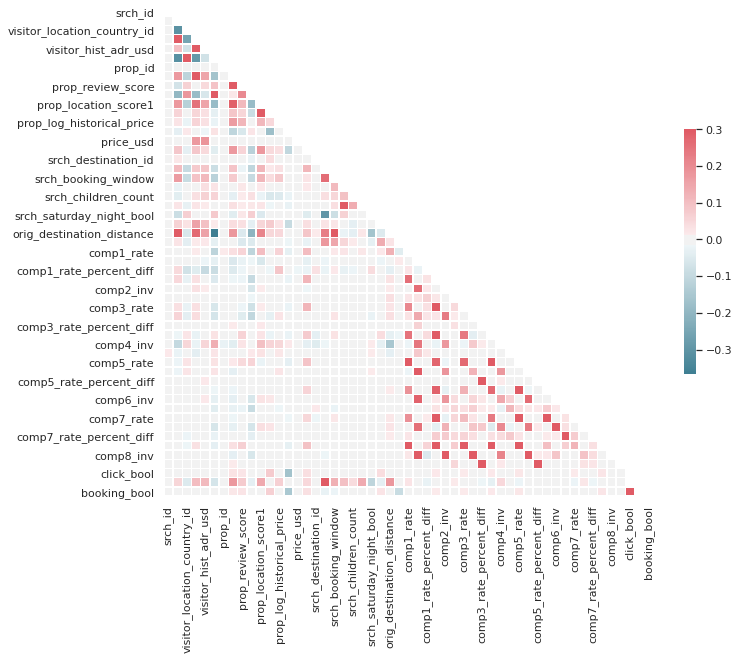

In [0]:
sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
feature_names = list(train.columns)[:27]

In [0]:
def nanrate(train, valname):
    ## train, the dataset name
    ## valname, the feature name to study
    train[valname+"_na"] = pd.isnull(train[valname])
    book_rate=[]
    click_rate=[]
    c_summary=[]
    b_summary=[]
    cond = []
    for i, gb in train.groupby(valname+"_na"):
        if i:
            cond.append(1)
        else:
            cond.append(0)
        book_rate.append(gb["booking_bool"].mean())
        click_rate.append(gb["click_bool"].mean())
        c_summary.append(gb["click_bool"].describe())
        b_summary.append(gb["booking_bool"].describe())
    df = pd.DataFrame(np.array([cond, click_rate, book_rate]), index=["Condition","Click Rate", "Book Rate"])
    df = df.transpose()
    #print(df)
    df.plot( x="Condition",kind="bar")
    locs, labels = plt.xticks()
    plt.xticks(locs, ["Not NULL", "NULL"], size='small', rotation='horizontal')
    plt.title("Click and booking rate of non-NA samples and Null features, wrt:"+valname)
    plt.show()


In [0]:
def ratedist(train, name, steps, navalue):
    ## train, dataset name
    ## name, the feature name
    ## steps, the interval size we are going to split the feature data with
    ## navalue, a special value for the na samples, can be -1, or -100
    print("Here the NULL values are classed as "+str(navalue))
    train[name+"_step"] = np.round(train[name]/steps)
    train[name+"_step"][pd.isnull(train[name])] = navalue
    rate_list = []
    c_per_list = []
    b_per_list = []
    for rate, gp in train.groupby(name+"_step"):
        rate_list.append(rate)
        c_per_list.append(1.0*gp["click_bool"].mean())
        b_per_list.append(1.0*gp["booking_bool"].mean())
    df = pd.DataFrame(np.array([rate_list, c_per_list, b_per_list]), index=["levels","c_per", "b_per"])
    df = df.transpose()
    df.plot(x="levels", y="c_per", kind="bar")
    plt.title("Click rate against "+name)
    plt.show()
    df.plot(x="levels", y="b_per", kind="bar")
    plt.title("Booking rate against "+name)
    plt.show()

In [0]:
print(train["visitor_hist_starrating"].describe())
train["visitor_hist_starrating"].hist()
plt.title("Distribution of visitor_hist_starrating")

NameError: ignored

In [0]:
x = pd.isnull(train["visitor_hist_starrating"]).sum()
y = train.shape[0]
print(x/(1.0*y))

0.949203635808466


Text(0.5, 1.0, 'Distribution of visitor_hist_starrating (Group By booking_bool)')

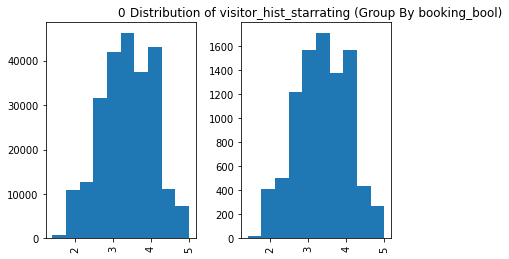

In [0]:
train['visitor_hist_starrating'].hist(by=train['booking_bool'])
plt.title("Distribution of visitor_hist_starrating (Group By booking_bool)", horizontalalignment='center')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e806ae198>,
      dtype=object)

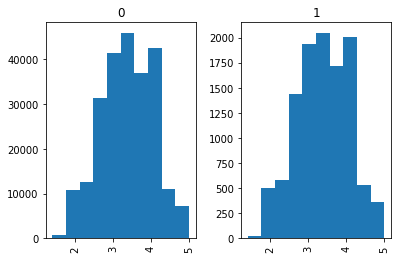

In [0]:
train['visitor_hist_starrating'].hist(by=train['click_bool'])

In [0]:
for i, gb in train.groupby("click_bool"):
    print(i)
    print(gb["visitor_hist_starrating"].describe())

0
count    240724.000000
mean          3.373956
std           0.692251
min           1.410000
25%           2.920000
50%           3.450000
75%           3.930000
max           5.000000
Name: visitor_hist_starrating, dtype: float64
1
count    11142.000000
mean         3.382512
std          0.698250
min          1.410000
25%          2.920000
50%          3.460000
75%          3.950000
max          5.000000
Name: visitor_hist_starrating, dtype: float64


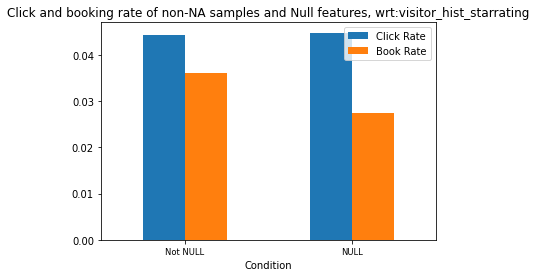

In [0]:

## the function nanrate was defined ealier on the top of this book
nanrate(train, "visitor_hist_starrating")

Here the NULL values are classed as -1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


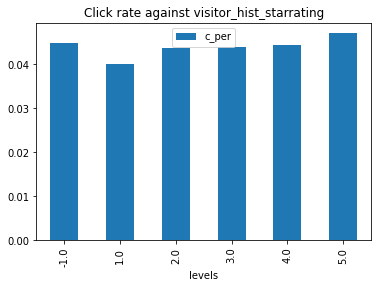

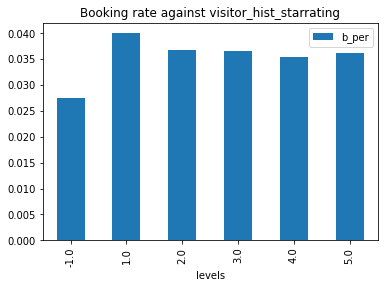

In [0]:
ratedist(train, "visitor_hist_starrating", 1, -1)

Here the NULL values are classed as -1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


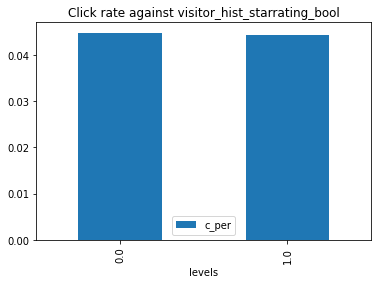

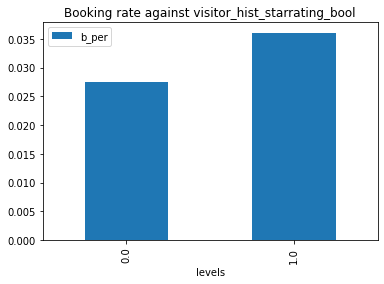

In [0]:
train['visitor_hist_starrating_bool'] = pd.notnull(train['visitor_hist_starrating'])
ratedist(train, "visitor_hist_starrating_bool", 1, -1)


Text(0.5, 1.0, 'The visitor_hist_adr_usd Distribution')

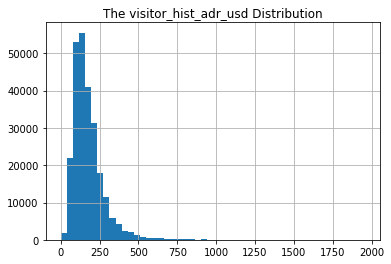

In [0]:
train['visitor_hist_adr_usd'].hist(bins=50)
plt.title("The visitor_hist_adr_usd Distribution")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e804159e8>,
      dtype=object)

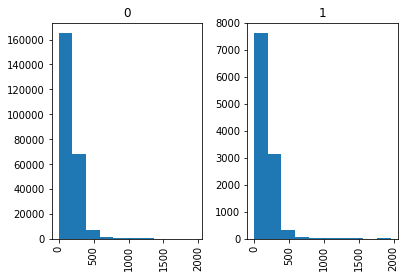

In [0]:
train['visitor_hist_adr_usd'].hist(by=train['click_bool'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e8038f860>,
      dtype=object)

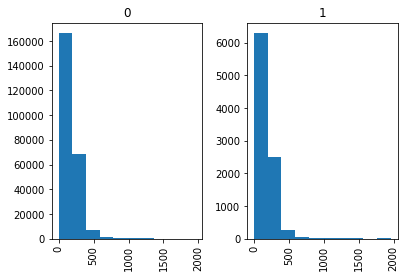

In [0]:

train['visitor_hist_adr_usd'].hist(by=train['booking_bool'])

In [0]:
for i, gb in train.groupby("click_bool"):
    if i:
        C1 = gb["visitor_hist_adr_usd"].describe().to_frame()
    else:
        C0 = gb["visitor_hist_adr_usd"].describe().to_frame()
for i, gb in train.groupby("booking_bool"):
    if i:
        B1 = gb["visitor_hist_adr_usd"].describe().to_frame()
    else:
        B0 = gb["visitor_hist_adr_usd"].describe().to_frame()

In [0]:
#pd.concat([C0,C1], axis=1)
print(pd.concat([pd.concat([C0,C1], axis=1), pd.concat([B0,B1], axis=1)], axis=0))

       visitor_hist_adr_usd  visitor_hist_adr_usd
count         241786.000000          11202.000000
mean             175.933587            177.945215
std              107.105660            110.405435
min                0.000000              0.000000
25%              109.770000            110.335000
50%              152.160000            152.910000
75%              213.360000            215.402500
max             1958.700000           1958.700000
count         243854.000000           9134.000000
mean             176.010166            176.356201
std              107.115839            110.897632
min                0.000000              0.000000
25%              109.810000            109.690000
50%              152.250000            151.305000
75%              213.570000            212.205000
max             1958.700000           1958.700000


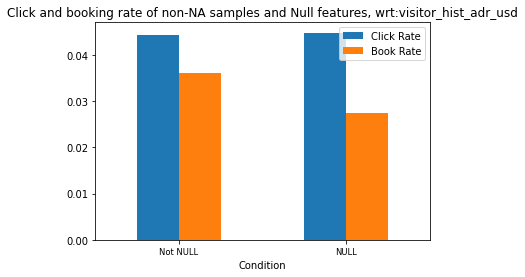

In [0]:
nanrate(train, "visitor_hist_adr_usd" )

Here the NULL values are classed as -1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


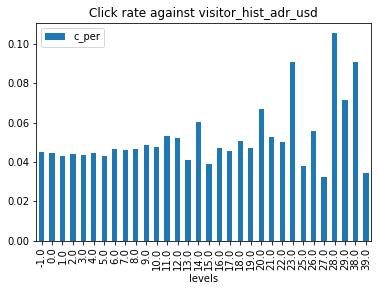

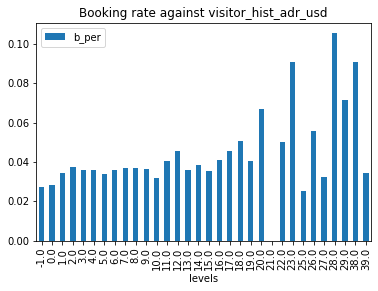

In [0]:
ratedist(train, "visitor_hist_adr_usd", 50, -1)

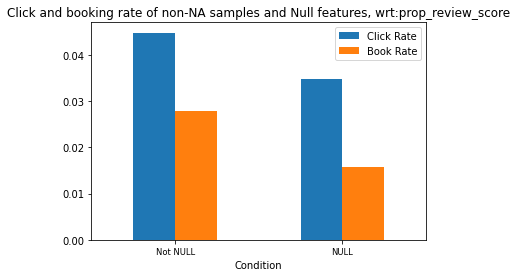

In [0]:
nanrate(train, "prop_review_score")

Here the NULL values are classed as -1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


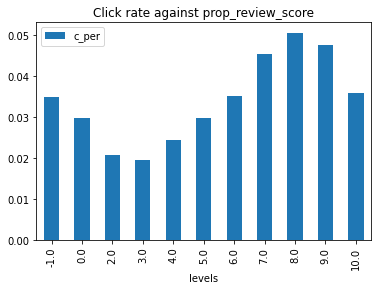

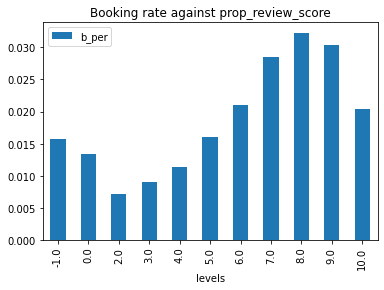

In [0]:

ratedist(train, "prop_review_score", 0.5, -1)

In [0]:

train['prop_review_score'].fillna(3, inplace=True)
train['prop_review_score'][train['prop_review_score']==0]=2.5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here the NULL values are classed as -1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


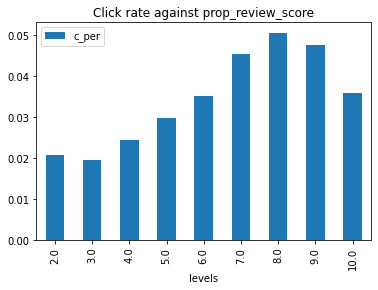

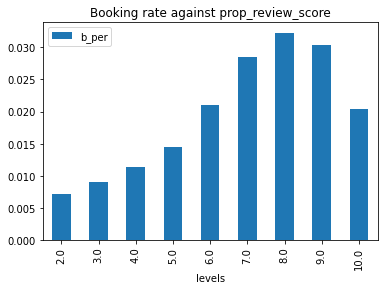

In [0]:
ratedist(train, "prop_review_score", 0.5, -1)

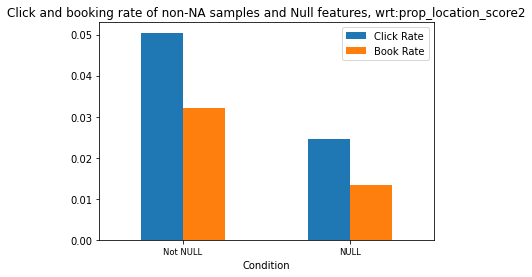

count    3.867999e+06
mean     1.303852e-01
std      1.594634e-01
min      0.000000e+00
25%      1.900000e-02
50%      6.900000e-02
75%      1.805000e-01
max      1.000000e+00
Name: prop_location_score2, dtype: float64

In [0]:
nanrate(train, "prop_location_score2")
train["prop_location_score2"].describe()

Here the NULL values are classed as -0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


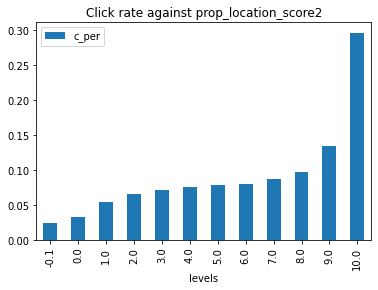

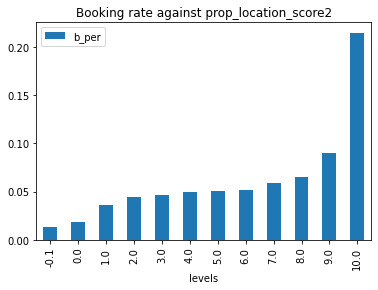

In [0]:
ratedist(train, "prop_location_score2", 0.1, -0.1)

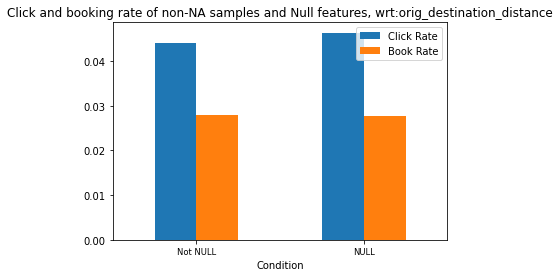

count    3.350565e+06
mean     1.301234e+03
std      2.023951e+03
min      1.000000e-02
25%      1.398000e+02
50%      3.866000e+02
75%      1.500670e+03
max      1.166664e+04
Name: orig_destination_distance, dtype: float64

In [0]:
nanrate(train, "orig_destination_distance")
train["orig_destination_distance"].describe()


In [0]:
## the orig_destination_distance looks not flat, we use log function to make it flat
train["orig_destination_distance_log"] = np.log(train["orig_destination_distance"])
train["orig_destination_distance_log"].describe()

count    3.350565e+06
mean     5.961194e+00
std      1.855231e+00
min     -4.605170e+00
25%      4.940213e+00
50%      5.957391e+00
75%      7.313667e+00
max      9.364489e+00
Name: orig_destination_distance_log, dtype: float64

Here the NULL values are classed as -6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


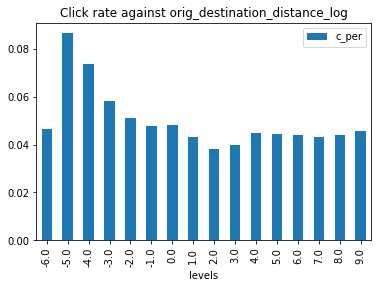

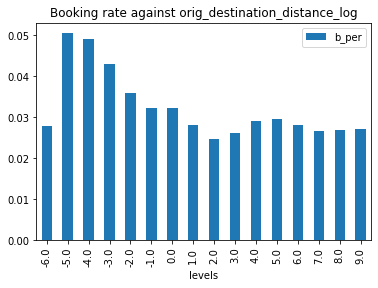

In [0]:
ratedist(train, "orig_destination_distance_log", 1, -6)

Here the NULL values are classed as -6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


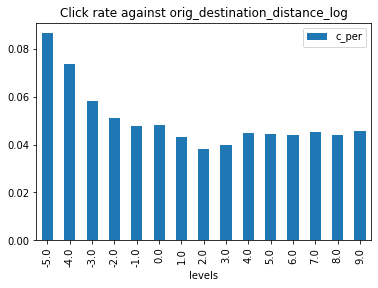

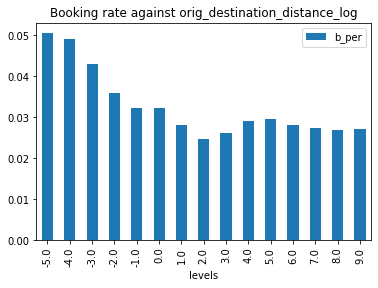

In [0]:

train["orig_destination_distance"].fillna(1509,inplace=True)
train["orig_destination_distance_log"] = np.log(train["orig_destination_distance"])
ratedist(train, "orig_destination_distance_log", 1, -6)

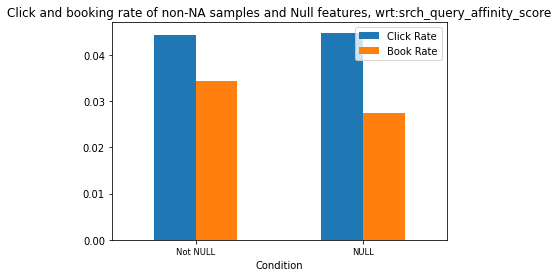

count    317406.000000
mean        -24.146418
std          15.743238
min        -326.567500
25%         -30.774775
50%         -20.451300
75%         -13.350625
max          -2.494100
Name: srch_query_affinity_score, dtype: float64

In [0]:
nanrate(train, "srch_query_affinity_score")
train["srch_query_affinity_score"].describe()

In [0]:
train["srch_query_affinity_score_log"] = np.log(-train["srch_query_affinity_score"])
train["srch_query_affinity_score_log"].describe()


count    317406.000000
mean          3.002842
std           0.606751
min           0.913928
25%           2.591563
50%           3.018046
75%           3.426695
max           5.788637
Name: srch_query_affinity_score_log, dtype: float64

Here the NULL values are classed as 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


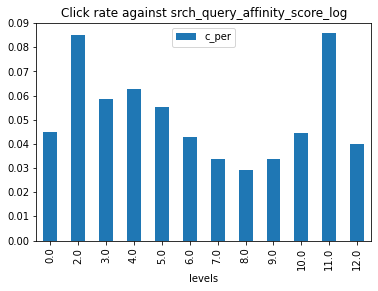

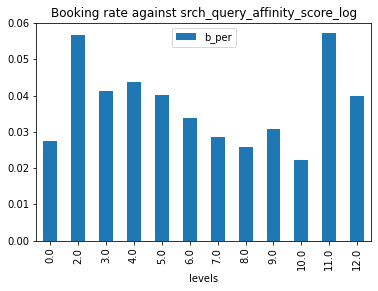

In [0]:
ratedist(train, "srch_query_affinity_score_log", 0.5, 0)

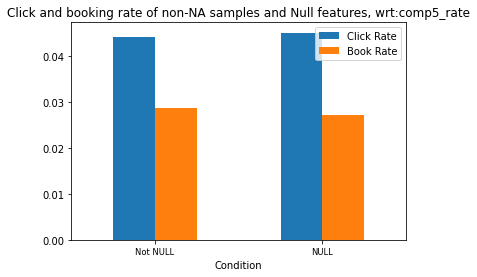

count    2.222373e+06
mean     2.267621e-02
std      5.217575e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: comp5_rate, dtype: float64
Here the NULL values are classed as -2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


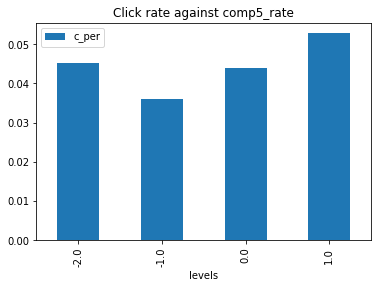

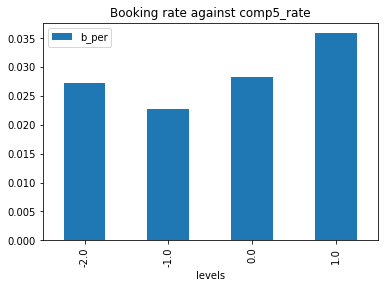

In [0]:
nanrate(train, "comp5_rate")
print(train["comp5_rate"].describe())
ratedist(train, "comp5_rate", 1, -2)

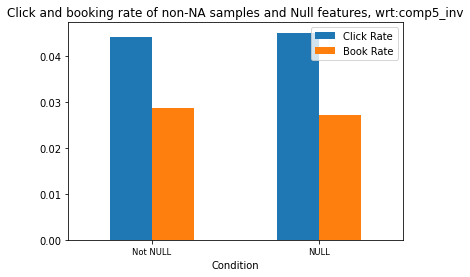

count    2.360020e+06
mean     5.142880e-02
std      2.678363e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: comp5_inv, dtype: float64
Here the NULL values are classed as -2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


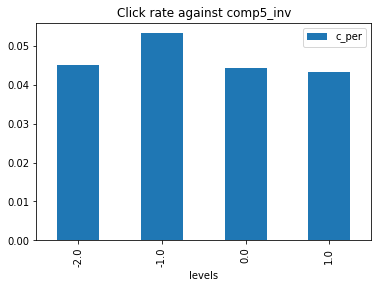

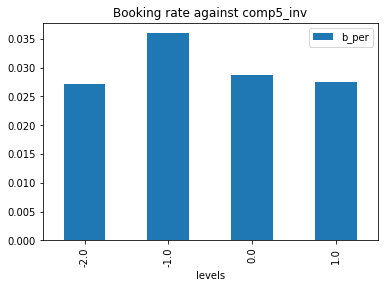

In [0]:

nanrate(train, "comp5_inv")
print(train["comp5_inv"].describe())
ratedist(train, "comp5_inv", 1, -2)

Here the NULL values are classed as -2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


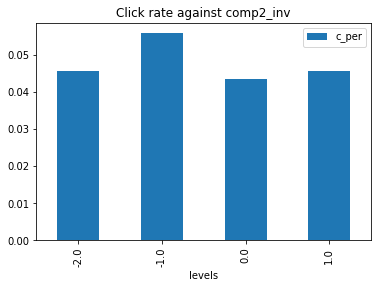

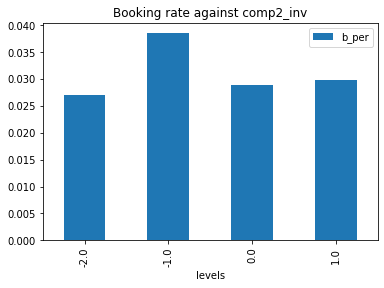

In [0]:
ratedist(train, "comp2_inv", 1, -2)

Here the NULL values are classed as -2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


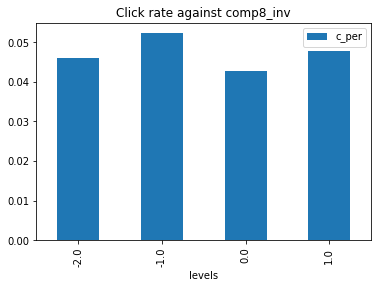

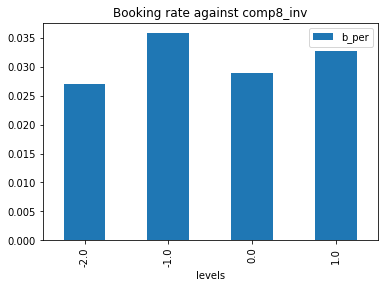

In [0]:
ratedist(train, "comp8_inv", 1, -2)

Here the NULL values are classed as -2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


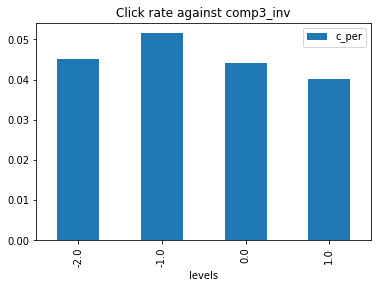

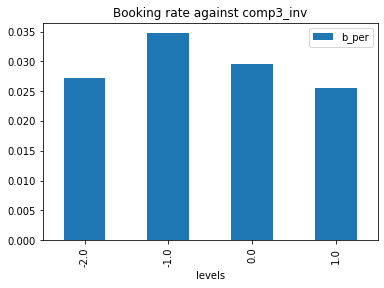

In [0]:

ratedist(train, "comp3_inv", 1, -2)

In [0]:
for i in range(1,9):
    train['comp'+str(i)+'_inv'].fillna(0, inplace=True)
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==1] = 10
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==-1] = 1
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==0] = -1
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==10] = 0
train['comp_inv_sum'] = train['comp1_inv']
for i in range(2,9):
    train['comp_inv_sum'] += train['comp'+str(i)+'_inv']
train['comp_inv_sum'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

count    4.958347e+06
mean    -7.847542e+00
std      5.727433e-01
min     -8.000000e+00
25%     -8.000000e+00
50%     -8.000000e+00
75%     -8.000000e+00
max      4.000000e+00
Name: comp_inv_sum, dtype: float64

Here the NULL values are classed as -9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


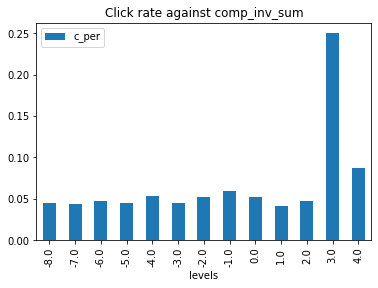

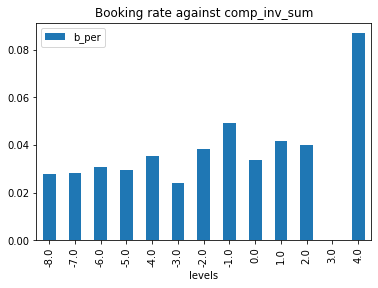

In [0]:
ratedist(train, "comp_inv_sum", 1, -9)

In [0]:

for i in range(1,9):
    train['comp'+str(i)+'_rate'].fillna(0, inplace=True)
train['comp_rate_sum'] = train['comp1_rate']
for i in range(2,9):
    train['comp_rate_sum'] += train['comp'+str(i)+'_rate']
train['comp_rate_sum'].describe()

count    4.958347e+06
mean     3.609590e-02
std      8.868623e-01
min     -6.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: comp_rate_sum, dtype: float64

Here the NULL values are classed as -7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


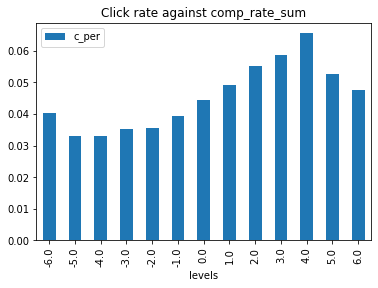

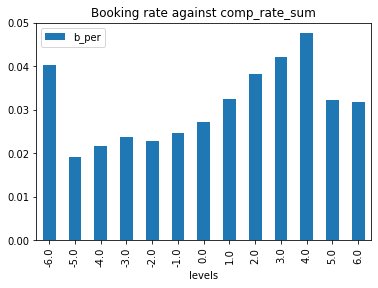

In [0]:
ratedist(train, "comp_rate_sum", 1, -7)

In [0]:
train['comp_sum'] = train['comp1_rate'] + train['comp1_inv'] + 2
for i in range(2,9):
    train['comp_sum'] += train['comp'+str(i)+'_rate'] + train['comp'+str(i)+'_inv']

In [0]:
train["comp_sum"].describe()

count    4.958347e+06
mean    -5.811446e+00
std      1.055148e+00
min     -1.200000e+01
25%     -6.000000e+00
50%     -6.000000e+00
75%     -6.000000e+00
max      9.000000e+00
Name: comp_sum, dtype: float64

Here the NULL values are classed as -13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


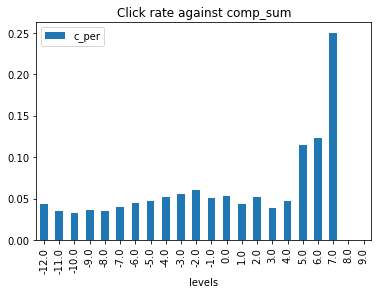

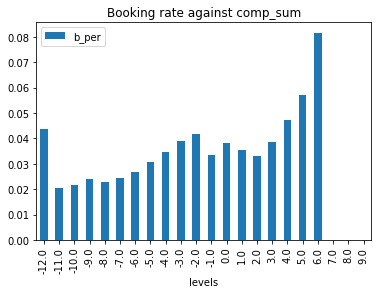

In [0]:
ratedist(train, "comp_sum", 1, -13)

Here the NULL values are classed as -2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


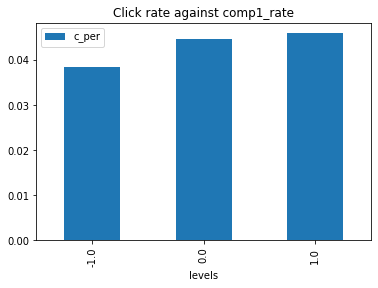

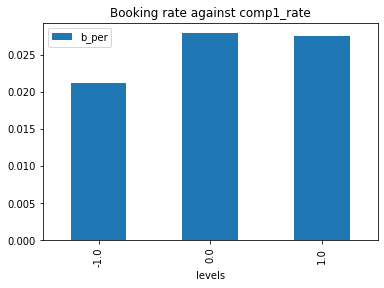

Here the NULL values are classed as -2


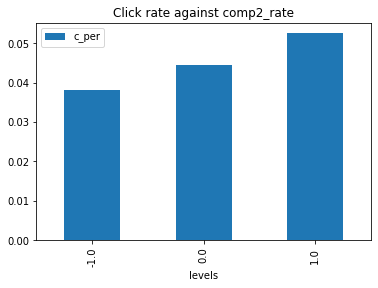

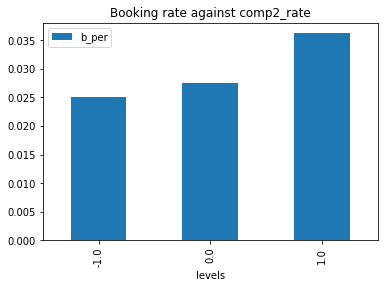

Here the NULL values are classed as -2


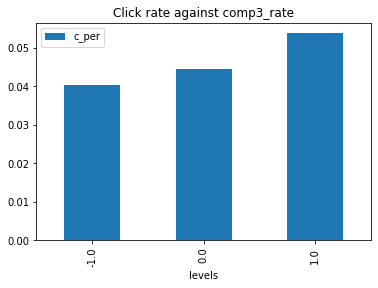

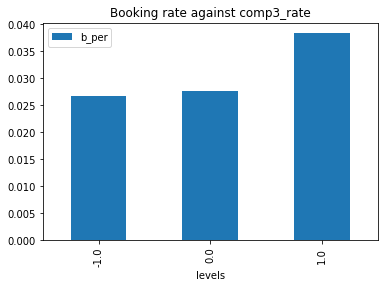

Here the NULL values are classed as -2


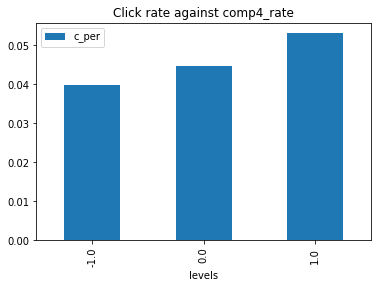

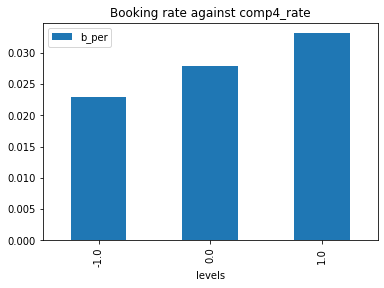

Here the NULL values are classed as -2


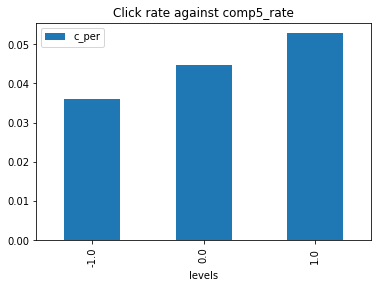

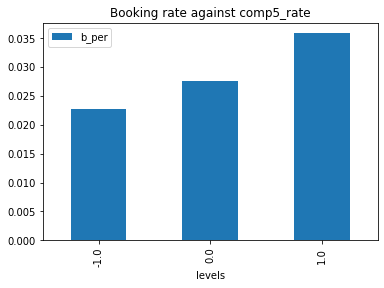

Here the NULL values are classed as -2


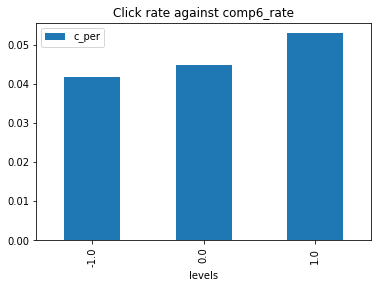

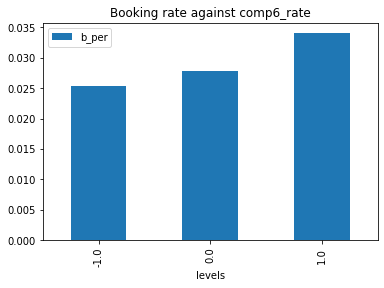

Here the NULL values are classed as -2


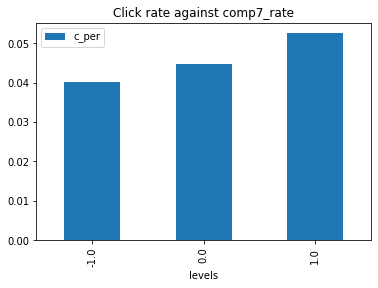

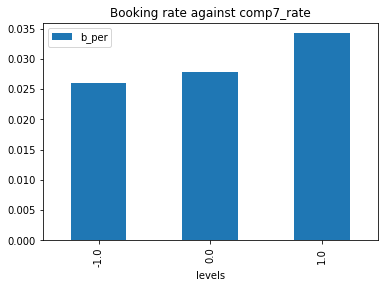

Here the NULL values are classed as -2


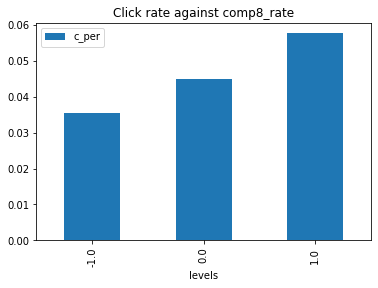

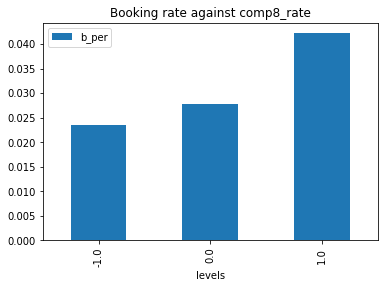

In [0]:
for i in range(1,9):
    ratedist(train, 'comp'+str(i)+'_rate', 1, -2)